In [45]:
!pip install opencv-python


[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import re
from mpl_toolkits.mplot3d import Axes3D

# تنظیمات نمایش نمودار
%matplotlib inline

def parse_calibration_scaled(calib_file, image_shape):
    """
    خواندن ماتریس K و عرض تصویر از فایل و تغییر مقیاس دقیق.
    """
    img_h, img_w = image_shape[:2]
    
    try:
        with open(calib_file, 'r') as f:
            content = f.read()
        
        # 1. استخراج ماتریس K
        pattern_k = r"cam0=\[(.*?)\]"
        match_k = re.search(pattern_k, content, re.DOTALL)
        
        if match_k:
            str_matrix = match_k.group(1).replace(';', ' ')
            K = np.fromstring(str_matrix, sep=' ').reshape(3, 3)
        else:
            raise ValueError("Could not find cam0 matrix.")

        # 2. استخراج عرض اصلی تصویر (width) از فایل
        # این بخش جایگزین حدس زدن بر اساس cx می‌شود
        pattern_w = r"width=(\d+)"
        match_w = re.search(pattern_w, content)
        
        if match_w:
            original_width = float(match_w.group(1))
        else:
            # اگر width در فایل نبود، به روش تخمینی برمی‌گردیم
            print("Warning: 'width' not found in calib.txt. Estimating from cx.")
            original_width = K[0, 2] * 2
        
        # 3. محاسبه ضریب مقیاس دقیق
        scale_x = img_w / original_width
        
        # بررسی و اعمال اسکیل
        if abs(scale_x - 1.0) > 0.01: # حساسیت را دقیق‌تر کردیم
            print(f"Scaling K matrix by factor: {scale_x:.4f} (Image: {img_w} vs Original: {original_width})")
            K[0, 0] *= scale_x # fx
            K[1, 1] *= scale_x # fy
            K[0, 2] *= scale_x # cx
            K[1, 2] *= scale_x # cy
        else:
            print("Calibration matches image size. No scaling needed.")
            
        return K

    except Exception as e:
        print(f"Error loading calibration: {e}")
        # بازگرداندن ماتریس دامی در صورت خطا
        return np.array([[img_w, 0, img_w/2], [0, img_w, img_h/2], [0, 0, 1]], dtype=float)
    


    
def draw_epipolar_lines_bold(img1, img2, lines, pts1, pts2):
    """رسم خطوط اپی‌پولار و نقاط با استایل پررنگ و واضح"""
    r, c = img1.shape
    img1_color = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2_color = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    
    for r_line, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        
        # محاسبه مختصات خط: ax + by + c = 0
        x0, y0 = map(int, [0, -r_line[2]/r_line[1]])
        x1, y1 = map(int, [c, -(r_line[2]+r_line[0]*c)/r_line[1]])
        
        # رسم خط با ضخامت بالا (3)
        cv2.line(img1_color, (x0, y0), (x1, y1), color, 3)
        
        # رسم نقاط به صورت دایره توپر با شعاع زیاد (10)
        pt1_int = (int(pt1[0]), int(pt1[1]))
        pt2_int = (int(pt2[0]), int(pt2[1]))
        cv2.circle(img1_color, pt1_int, 10, color, -1)
        cv2.circle(img2_color, pt2_int, 10, color, -1)
        
    return img1_color, img2_color

def compute_epipole(F):
    """محاسبه اپی‌پل‌ها از فضای پوچ ماتریس F"""
    U, S, Vt = np.linalg.svd(F)
    e1 = Vt[-1]
    e1 = e1 / e1[2] if abs(e1[2]) > 1e-6 else e1 # اپی‌پل چپ (Fe1 = 0)

    U, S, Vt = np.linalg.svd(F.T)
    e2 = Vt[-1]
    e2 = e2 / e2[2] if abs(e2[2]) > 1e-6 else e2 # اپی‌پل راست (e2.T F = 0)
    
    return e1, e2

Image loaded. Shape: (1896, 2996)
Calibration matches image size. No scaling needed.
Final Scaled K Matrix:
[[3.920793e+03 0.000000e+00 1.015603e+03]
 [0.000000e+00 3.920793e+03 9.633670e+02]
 [0.000000e+00 0.000000e+00 1.000000e+00]]
Keypoints found: Left=4912, Right=4829


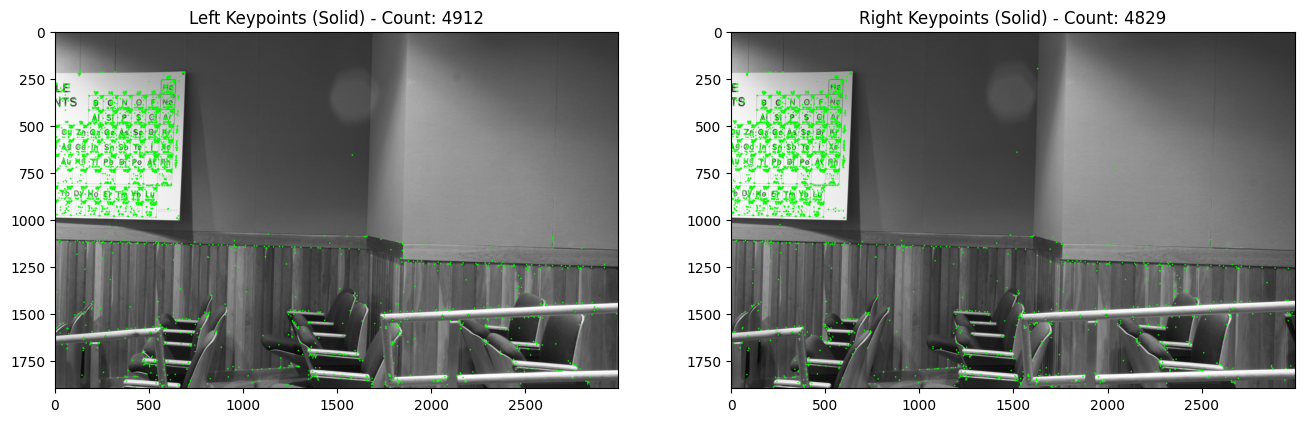

In [47]:
# 1. Load Images & SIFT
img1 = cv2.imread('im0.png', 0) 
img2 = cv2.imread('im1.png', 0)

if img1 is None or img2 is None:
    raise FileNotFoundError("Image files im0.png or im1.png not found.")

print(f"Image loaded. Shape: {img1.shape}")

# --- اعمال اصلاح حیاتی K ---
# فرض بر این است که تابع parse_calibration_scaled قبلاً تعریف شده است
K = parse_calibration_scaled('calib.txt', img1.shape)
print(f"Final Scaled K Matrix:\n{K}")

# SIFT Detection [cite: 81]
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

print(f"Keypoints found: Left={len(kp1)}, Right={len(kp2)}")

# --- تابع کمکی برای رسم نقاط توپر ---
def draw_solid_keypoints(image, keypoints, color=(0, 255, 0), radius=4):
    """
    رسم نقاط کلیدی به صورت دایره‌های توپر روی تصویر
    """
    # تبدیل تصویر به رنگی (BGR) تا نقاط رنگی دیده شوند
    if len(image.shape) == 2:
        out_img = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        out_img = image.copy()
        
    for kp in keypoints:
        # استخراج مختصات (x, y)
        x, y = int(kp.pt[0]), int(kp.pt[1])
        
        # رسم دایره: thickness=-1 یعنی دایره توپر
        cv2.circle(out_img, (x, y), radius, color, -1)
        
    return out_img

# استفاده از تابع جدید برای رسم
# رنگ سبز (0, 255, 0) و شعاع 4 پیکسل
img1_kp = draw_solid_keypoints(img1, kp1, color=(0, 255, 0), radius=4)
img2_kp = draw_solid_keypoints(img2, kp2, color=(0, 255, 0), radius=4)

# نمایش تصاویر [cite: 81, 82]
plt.figure(figsize=(16, 8))
plt.subplot(121), plt.imshow(img1_kp), plt.title(f'Left Keypoints (Solid) - Count: {len(kp1)}')
plt.subplot(122), plt.imshow(img2_kp), plt.title(f'Right Keypoints (Solid) - Count: {len(kp2)}')
plt.show()

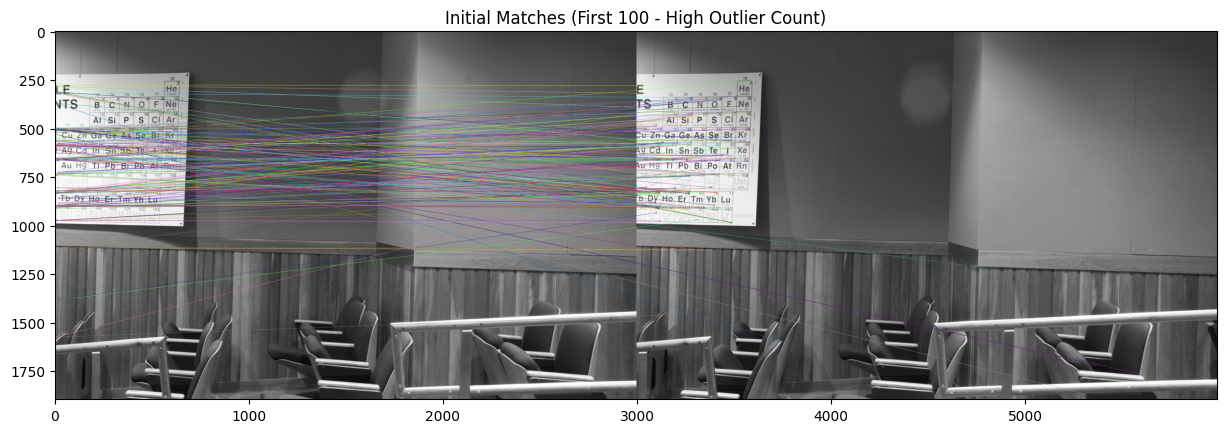

Total Matches: 4912
Matches after Ratio Test: 2521


In [48]:
# 2. Feature Matching
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# --- نمایش تطبیق‌های اولیه (خواسته شده در تمرین) ---
# نمایش 100 تطبیق خام قبل از فیلتر Lowe's
img_matches_initial = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches[:100], None, flags=2)
plt.figure(figsize=(15, 6))
plt.imshow(img_matches_initial)
plt.title("Initial Matches (First 100 - High Outlier Count)")
plt.show()

# --- اعمال فیلتر Lowe's Ratio ---
good_matches = []
ratio_thresh = 0.75
for m, n in matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)

print(f"Total Matches: {len(matches)}")
print(f"Matches after Ratio Test: {len(good_matches)}")

pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

In [49]:
# 3. Fundamental Matrix & RANSAC
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, 1.0, 0.99)

pts1_inliers = pts1[mask.ravel() == 1]
pts2_inliers = pts2[mask.ravel() == 1]

inlier_percentage = len(pts1_inliers)/len(good_matches)*100
print(f"Inliers: {len(pts1_inliers)} / {len(good_matches)} ({inlier_percentage:.2f}%)")
print(f"Fundamental Matrix F:\n{F}")

# --- بررسی عددی قید اپی‌پولار (خواسته شده در تمرین) ---
print("\nVerifying Epipolar Constraint (x' * F * x should be ~0):")
print("-" * 40)
for i in range(min(5, len(pts1_inliers))):
    # مختصات همگن (x, y, 1)
    p1 = np.array([pts1_inliers[i][0], pts1_inliers[i][1], 1])
    p2 = np.array([pts2_inliers[i][0], pts2_inliers[i][1], 1])
    
    val = p2 @ F @ p1
    print(f"Pair {i}: {val:.6e}") # نمایش به صورت علمی برای دقت

# --- محاسبه و گزارش Epipoleها ---
e1, e2 = compute_epipole(F)
print("\n--- Epipole Calculation ---")
print(f"Left Epipole (e1): {e1}")
print(f"Right Epipole (e2): {e2}")
print("Interpretation: Large values indicate the epipoles are near infinity, typical for rectified stereo pairs.")

Inliers: 1978 / 2521 (78.46%)
Fundamental Matrix F:
[[ 1.76870927e-08  2.60440547e-06 -2.84746533e-02]
 [-3.57632587e-06 -2.27672774e-08  1.50622179e+00]
 [ 2.88950773e-02 -1.50730927e+00  1.00000000e+00]]

Verifying Epipolar Constraint (x' * F * x should be ~0):
----------------------------------------
Pair 0: 2.177835e-01
Pair 1: 4.529111e-01
Pair 2: 6.315488e-01
Pair 3: -4.166115e-01
Pair 4: -1.851125e-01

--- Epipole Calculation ---
Left Epipole (e1): [4.21113187e+05 8.07339164e+03 1.00000000e+00]
Right Epipole (e2): [5.78849346e+05 1.09423024e+04 1.00000000e+00]
Interpretation: Large values indicate the epipoles are near infinity, typical for rectified stereo pairs.


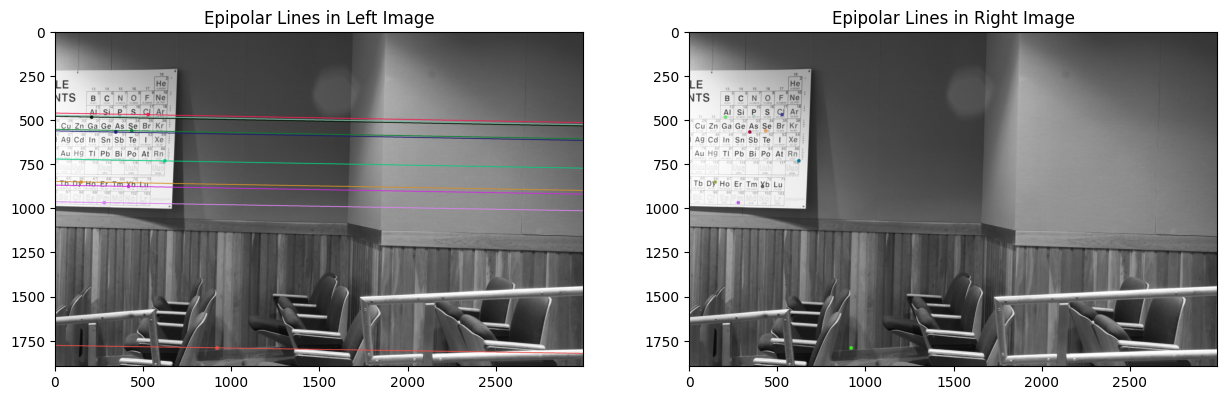

In [50]:
# 4. Visualize Epipolar Lines (Bold Style)
indexes = np.random.randint(0, len(pts1_inliers), min(10, len(pts1_inliers))) # رسم 10 خط
src_pts = pts1_inliers[indexes]
dst_pts = pts2_inliers[indexes]

# محاسبه خطوط اپی‌پولار متناظر با نقاط تصویر راست (lines1) روی تصویر چپ
lines1 = cv2.computeCorrespondEpilines(dst_pts.reshape(-1, 1, 2), 2, F).reshape(-1, 3)

# محاسبه خطوط اپی‌پولار متناظر با نقاط تصویر چپ (lines2) روی تصویر راست
lines2 = cv2.computeCorrespondEpilines(src_pts.reshape(-1, 1, 2), 1, F).reshape(-1, 3)

# رسم
img_lines1, _ = draw_epipolar_lines_bold(img1, img2, lines1, src_pts, dst_pts)
_, img_lines2 = draw_epipolar_lines_bold(img2, img1, lines2, dst_pts, src_pts)

plt.figure(figsize=(15, 7))
plt.subplot(121), plt.imshow(img_lines1), plt.title('Epipolar Lines in Left Image')
plt.subplot(122), plt.imshow(img_lines2), plt.title('Epipolar Lines in Right Image')
plt.show()

In [51]:
# 5. Essential Matrix & Recover Pose
E = K.T @ F @ K
print(f"Essential Matrix E:\n{E}")

# تطبیق نوع داده‌ها (Type Casting)
pts1_f64 = pts1_inliers.astype(np.float64)
pts2_f64 = pts2_inliers.astype(np.float64)
K_f64 = K.astype(np.float64)

# بازیابی R و t با شرط Cheirality (انتخاب بهترین از ۴ حالت)
points, R, t, mask_pose = cv2.recoverPose(E, pts1_f64, pts2_f64, K_f64)

print("\nRecovered Camera Motion:")
print(f"Rotation R:\n{R}")
print(f"Translation t:\n{t}")

# --- بررسی حیاتی: تعداد نقاط بعد از Cheirality Check ---
if mask_pose is not None:
    mask_pose = mask_pose.ravel() > 0
    pts1_final = pts1_inliers[mask_pose]
    pts2_final = pts2_inliers[mask_pose]
else:
    # در صورت عدم موفقیت recoverPose (بسیار نادر)
    pts1_final = pts1_inliers
    pts2_final = pts2_inliers
    
print(f"Points remaining after Cheirality Check: {len(pts1_final)} / {len(pts1_inliers)}.")
print("If this number is close to the Inliers count, the calibration scaling was successful.")

Essential Matrix E:
[[ 2.71896915e-01  4.00365297e+01 -1.01735529e+02]
 [-5.49774905e+01 -3.49992653e-01  5.89125705e+03]
 [ 9.98536819e+01 -5.89956298e+03 -5.74470043e-01]]

Recovered Camera Motion:
Rotation R:
[[ 9.99996700e-01 -3.44423676e-04  2.54584483e-03]
 [ 3.44164897e-04  9.99999936e-01  1.02084937e-04]
 [-2.54587982e-03 -1.01208409e-04  9.99996754e-01]]
Translation t:
[[-0.99982791]
 [-0.01726659]
 [-0.00678416]]
Points remaining after Cheirality Check: 165 / 1978.
If this number is close to the Inliers count, the calibration scaling was successful.


Successfully reconstructed 165 3D points.


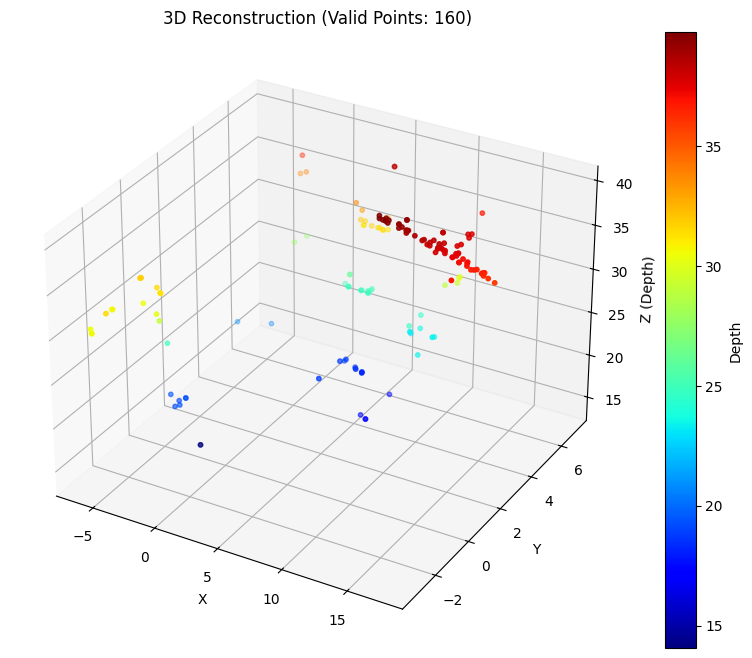

In [52]:
# 6. Triangulation & 3D Visualization
# ساخت ماتریس‌های پروجکشن (P1=K[I|0], P2=K[R|t])
P1 = K_f64 @ np.hstack((np.eye(3), np.zeros((3, 1))))
P2 = K_f64 @ np.hstack((R, t))

# تبدیل فرمت برای مثلث‌سازی: (2, N) و float32
pts1_tri = pts1_final.reshape(-1, 2).T.astype(np.float32)
pts2_tri = pts2_final.reshape(-1, 2).T.astype(np.float32)
P1_tri = P1.astype(np.float32)
P2_tri = P2.astype(np.float32)

if pts1_tri.shape[1] == 0:
    print("Error: No points remain for triangulation.")
else:
    # مثلث‌سازی
    pts4D = cv2.triangulatePoints(P1_tri, P2_tri, pts1_tri, pts2_tri)
    
    # تبدیل همگن به اقلیدسی (N, 3)
    pts3D = pts4D[:3] / pts4D[3]
    pts3D = pts3D.T
    
    print(f"Successfully reconstructed {len(pts3D)} 3D points.")

    # 3D Visualization
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    z_vals = pts3D[:, 2]
    
    # فیلتر کردن نقاط پرت (عمق منفی یا بسیار دور)
    valid_mask = (z_vals > 0) & (z_vals < np.percentile(z_vals, 98))
    pts3D_vis = pts3D[valid_mask]
    z_vals_vis = z_vals[valid_mask]

    sc = ax.scatter(pts3D_vis[:, 0], pts3D_vis[:, 1], z_vals_vis, 
               c=z_vals_vis, cmap='jet', s=10)

    plt.colorbar(sc, label='Depth')
    ax.set_xlabel('X'), ax.set_ylabel('Y'), ax.set_zlabel('Z (Depth)')
    ax.set_title(f'3D Reconstruction (Valid Points: {len(pts3D_vis)})')
    ax.view_init(elev=30, azim=-60)
    plt.show()

Mean Reprojection Error - Image 1: 0.3247 px
Mean Reprojection Error - Image 2: 0.3249 px


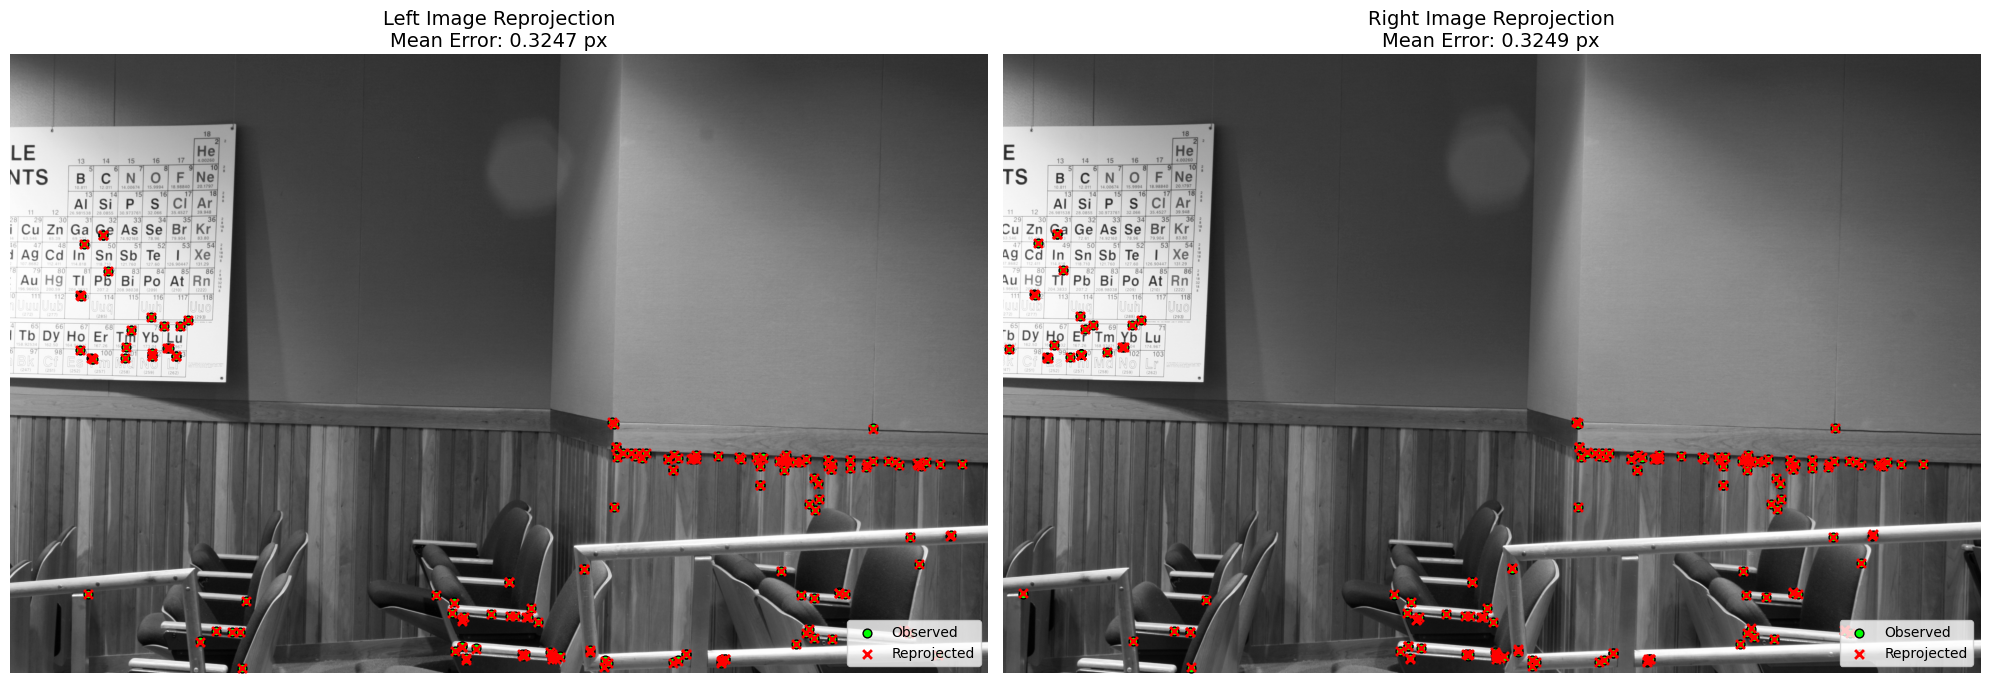

In [53]:
# 7. Reprojection Error Calculation and Visualization (Both Images)

if 'pts3D' not in locals():
    print("Cannot calculate reprojection error: 3D points are missing.")
else:
    # --- Project to Image 1 (Left Camera) ---
    rvec1, _ = cv2.Rodrigues(np.eye(3))
    tvec1 = np.zeros(3)
    imgpts1_proj, _ = cv2.projectPoints(pts3D, rvec1, tvec1, K_f64, None)
    imgpts1_proj = imgpts1_proj.reshape(-1, 2)
    err1 = np.linalg.norm(pts1_final - imgpts1_proj, axis=1)
    mean_err1 = np.mean(err1)

    # --- Project to Image 2 (Right Camera) ---
    rvec2, _ = cv2.Rodrigues(R)
    tvec2 = t
    imgpts2_proj, _ = cv2.projectPoints(pts3D, rvec2, tvec2, K_f64, None)
    imgpts2_proj = imgpts2_proj.reshape(-1, 2)
    err2 = np.linalg.norm(pts2_final - imgpts2_proj, axis=1)
    mean_err2 = np.mean(err2)

    print(f"Mean Reprojection Error - Image 1: {mean_err1:.4f} px")
    print(f"Mean Reprojection Error - Image 2: {mean_err2:.4f} px")

    # --- Visualization (Highlighting Residuals) ---
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    def plot_reproj(ax, img, real_pts, proj_pts, mean_err, title):
        ax.imshow(img, cmap='gray')
        
        # رسم نقاط واقعی (سبز)
        ax.scatter(real_pts[:, 0], real_pts[:, 1], c='lime', s=40, edgecolors='black', label='Observed')
        
        # رسم نقاط بازتابی (قرمز - ضربدر)
        ax.scatter(proj_pts[:, 0], proj_pts[:, 1], c='red', marker='x', s=40, linewidth=2, label='Reprojected')
        
        # رسم خط خطا (Residuals)
        for p_real, p_proj in zip(real_pts, proj_pts):
            ax.plot([p_real[0], p_proj[0]], [p_real[1], p_proj[1]], 'r-', alpha=0.4, linewidth=1)
            
        ax.set_title(f"{title}\nMean Error: {mean_err:.4f} px", fontsize=14)
        ax.legend(loc='lower right')
        ax.axis('off')

    plot_reproj(axes[0], img1, pts1_final, imgpts1_proj, mean_err1, "Left Image Reprojection")
    plot_reproj(axes[1], img2, pts2_final, imgpts2_proj, mean_err2, "Right Image Reprojection")
    
    plt.tight_layout()
    plt.show()